0. Use raw score (output_margin=True)
1. Run on all old labeled data
2. Run on new data
3. Map data on to Fladermaus
4. Collect the full trajectory of scores

In [2]:
# %load xgsea.py
import os
import pandas as pd
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import argparse
import random
import pickle

In [5]:
''' notes
max depth 8, num rounds 20 -> .85 r^2
             num rounds 30 -> .87

        + max_delta_step 2 -> .88

fixed data set
                           -> .89
added depthdiff column
                           -> .93
removed id column
                           -> .89
gamma=.7 parameter added
                           -> .89 (.002 increase)

jamstec
'eta': 1,
 'max_delta_step': 1,
 'max_depth': 11,
 'nthread': 4,
 'objective': 'binary:logistic',
 'silent': 1}              -> .87


'''

def read(f):
    # names = ['long','lat','depth','sigma_h','sigma_d','source_id','pred_depth','dens20', 'dens60','gravity','age','rate','sed thick', 'roughness', 'dens10']
    
    print('reading in data')
    #data = pd.read_csv(f, delimiter='\s+', names=names)
    data = pd.read_hdf(f)
    
    return make_xgstuff(clean(data))

def clean(data):
    y = 'sigma_d'
    # replace na with mean
    print('cleaning data')
    data.fillna(data.mean(), inplace=True)
    
    # change sigma_d to boolean, new method using list comprehension
    data[y] = [x == 9999 for x in data[y]]

    # create depthdiff column
    data['depthdiff'] = data['depth'] - data['pred_depth']

    # cleaner way to drop columns
    return data.drop(['depth', 'source_id'], axis=1)

def make_xgstuff(data):
    y = 'sigma_d'
    # split
    train, test = train_test_split(data, test_size=.3)

    # defines independent column names for test set
    x = [x != y for x in list(data.columns)]
    
    # splits dataframe into x and y vectors
    xtest = test.ix[:,x]
    ytest = test[y]

    xtrain = train.ix[:,x]
    ytrain = train[y]

    # convert to xgb data structures
    xgtrain = xgb.DMatrix(xtrain.values, ytrain.values, 
                          feature_names=list(xtrain.columns))
    xgtest = xgb.DMatrix(xtest.values, feature_names=list(xtrain.columns))
    
    return xgtrain, xgtest, ytest

In [ ]:
# if __name__ == '__main__':
# argument parser

"""
parser = argparse.ArgumentParser(description = 
    'generates xgb model from seafloor dataset')

parser.add_argument('dataset',
                    help = 'hdf dataset to model')

parser.add_argument('name', 
                    help = 'name of dataset')

arg = parser.parse_args()
"""

arg = {}
arg["dataset"] = "../nga.hdf5"
arg["name"] = "nga"

# housekeeping
random.seed(1105)

xgtrain, xgtest, ytest = read(arg["dataset"])

# parameters
param = {
    'jam': { # works well with geodas, sio also
        'max_depth':11, 
        'eta':1, 
        'silent':1, 
        'objective':'binary:logistic',
        'nthread':6,
        'max_delta_step':1
    },
    'nga': {
        'max_depth':10,
        'max_delta_step':2,
        'gamma':.7,
        'eta':1, 
        'objective':'binary:logistic',
        'nthread':4,
        'silent':1
    },
    'sio': {
        'max_depth':20,
        'eta':1,
        'silent':1,
        'objective':'binary:logistic',
        'nthread':6,
        'max_delta_step':1
    },
}

param['ngdc'] = {**param['jam'], 'max_depth':8}

num_round = 30

In [10]:
# train
print('training')

if arg["name"] not in param:
    print('no params found for dataset, using jamstec as default')
    name = 'jam'

else:
    name = arg["name"]

bst = xgb.train(param[name], xgtrain, num_round)

# test
#print('calculating r2')
preds = bst.predict(xgtest)

# print error
err = sum(1 for pred, actual in zip(preds, ytest) if (pred>.5)!=actual) / len(preds)
print('error: {:.2%}'.format(err))

# roc
print(metrics.roc_auc_score(ytest, preds))

training
error: 1.84%
0.997585161684


In [11]:
# save
pickle.dump((ytest, preds), open('dump.pkl', 'wb'))

In [29]:
ytest_array = np.array(ytest)
no_ytest_array = np.logical_not(ytest_array)

In [30]:
preds[ytest_array].shape, preds[no_ytest_array].shape

((319882,), (1324377,))

(0, 5000)

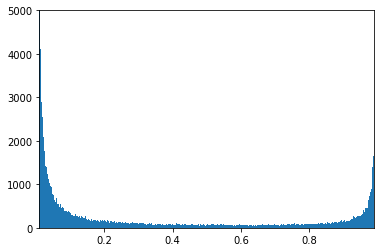

In [19]:
plt.hist(preds, bins=1000);
plt.xlim(0.01, 0.99)
plt.ylim(0, 5000)

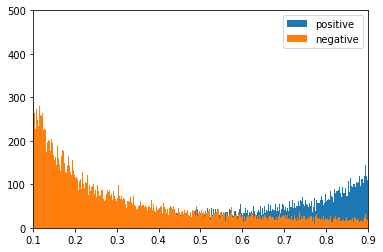

In [33]:
hist(preds[ytest_array], bins=1000, label="positive")
hist(preds[no_ytest_array], bins=1000, label="negative")
plt.xlim(0.1, 0.9)
plt.ylim(0, 500)
plt.legend();

In [ ]:
# save model
base_name = os.path.basename(arg.dataset)
type, _ = os.path.splitext(base_name)
# folder = '/Users/btea/models/{}'.format(type)

# makes folder if it dne
if not os.path.isdir(folder):
    os.mkdir(folder)

os.chdir(folder)

# dens
plt.style.use('ggplot')
pd.Series(data=preds, dtype='float32').plot.kde()
plt.tight_layout()
plt.savefig('dens.png')

'''bst.save_model('{:.4f}_error.model'.format(err))

plt.style.use('ggplot')
for t in ['gain', 'cover', 'weight']:
    xgb.plot_importance(bst, title=type, importance_type=t, show_values=False)
    plt.tight_layout()
    plt.savefig(t+'.png')'''